# Lab 01: Introduction to Experiment Tracking with TensorBoard

In this notebook, we'll explore **experiment tracking** — an essential practice for systematic machine learning development. Without proper tracking, you lose reproducibility, insights, and waste time repeating failed experiments.

![TensorBoard Dashboard](./images/image1.png)

The diagram above shows TensorBoard's dashboard where we can visualize training metrics, compare experiments, and analyze model performance in real-time.

**Our goal**: Learn to integrate TensorBoard with PyTorch, track training metrics systematically, and compare multiple experiments to identify what works best.

## Why Experiment Tracking Matters

Consider this scenario:
> *"Last week's model achieved 94% accuracy, but I can't remember the exact hyperparameters..."*

Without tracking, you lose:
- **Reproducibility** — Can't recreate successful results
- **Insights** — Don't know which changes helped
- **Efficiency** — Repeat failed experiments unknowingly

## Install Dependencies

First, let's install the required libraries:
- `torch` and `torchvision`: Core PyTorch libraries
- `tensorboard`: For experiment tracking and visualization
- `torchinfo`: To visualize model architecture
- Additional utilities for progress bars and visualization

In [29]:
!pip install torch torchvision --index-url https://download.pytorch.org/whl/cpu
!pip install tensorboard torchinfo matplotlib tqdm requests

Looking in indexes: https://download.pytorch.org/whl/cpu


## Import Libraries and Setup

We need:
- `torch`: Core PyTorch library
- `SummaryWriter`: TensorBoard's logging interface
- `tqdm`: For progress bars during training
- Various utilities for data handling and visualization

In [30]:
import torch
from torch import nn
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchinfo import summary

import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
from typing import Dict, List, Tuple
from pathlib import Path
import requests
import zipfile
from datetime import datetime
import os

print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")

PyTorch version: 2.9.1+cpu
Torchvision version: 0.24.1+cpu


## Setup Device

Using device-agnostic code allows our experiments to run on GPU (if available) or CPU. This flexibility is important for reproducibility across different hardware.

In [31]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


## 1. Get Data

We'll use the same food classification dataset as in transfer learning — 3 classes of food images:

This dataset helps us understand how experiment tracking works with a real computer vision problem.

In [32]:
# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Creating {image_path} directory...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading data...")
        f.write(request.content)

    # Unzip data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping data...") 
        zip_ref.extractall(image_path)

    print("Done!")

data/pizza_steak_sushi directory exists.


### Setup Directory Paths

The data follows the standard image classification structure:
- `train/` folder with subfolders for each class
- `test/` folder with the same structure

In [33]:
# Setup train and test directories
train_dir = image_path / "train"
test_dir = image_path / "test"

print(f"Training directory: {train_dir}")
print(f"Testing directory: {test_dir}")

# Count images in each class
for split in [train_dir, test_dir]:
    print(f"\n{split.name} set:")
    for class_dir in split.iterdir():
        if class_dir.is_dir():
            count = len(list(class_dir.glob("*.jpg")))
            print(f"  {class_dir.name}: {count} images")

Training directory: data/pizza_steak_sushi/train
Testing directory: data/pizza_steak_sushi/test

train set:
  pizza: 78 images
  steak: 75 images
  sushi: 72 images

test set:
  pizza: 25 images
  steak: 19 images
  sushi: 31 images


## 2. Create Transforms and DataLoaders

For our experiments, we'll use EfficientNet_B0 pretrained model. This requires specific data preprocessing:
- Resize to 224x224 pixels
- Normalize with ImageNet statistics

Using consistent transforms across experiments ensures fair comparison.

In [34]:
# Get automatic transforms from pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
auto_transforms = weights.transforms()

print("Transforms for EfficientNet_B0:")
print(auto_transforms)

Transforms for EfficientNet_B0:
ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


In [35]:
# Create datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=auto_transforms)
test_dataset = datasets.ImageFolder(root=test_dir, transform=auto_transforms)

# Get class names
class_names = train_dataset.classes
print(f"Classes: {class_names}")
print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Classes: ['pizza', 'steak', 'sushi']
Training samples: 225
Test samples: 75


In [36]:
# Create DataLoaders
BATCH_SIZE = 32

train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

print(f"Training batches: {len(train_dataloader)}")
print(f"Test batches: {len(test_dataloader)}")

Training batches: 8
Test batches: 3


## 3. Understanding TensorBoard Integration

TensorBoard provides a web interface to visualize experiments. The workflow involves:

1. **Create a SummaryWriter** — Points to a log directory
2. **Log metrics** — Record values during training
3. **Visualize** — View in the TensorBoard web interface

![TensorBoard Workflow](./images/image2.png)

Let's start with a simple example:

In [37]:
# Create a writer for a simple example
example_writer = SummaryWriter("runs/example_experiment")

# Simulate logging some metrics
for i in range(10):
    example_writer.add_scalar("Loss/train", 1.0 / (i + 1), i)
    example_writer.add_scalar("Accuracy/test", i * 10, i)

example_writer.close()
print("Example metrics logged! Launch TensorBoard to view them.")
print("Run in terminal: tensorboard --logdir runs")

Example metrics logged! Launch TensorBoard to view them.
Run in terminal: tensorboard --logdir runs


### Key TensorBoard Methods

| Method | Purpose | Example |
|--------|---------|----------|
| `add_scalar()` | Log single values | Loss, accuracy, learning rate |
| `add_scalars()` | Log multiple values | Train vs validation loss |
| `add_histogram()` | Log distributions | Weight distributions |
| `add_image()` | Log images | Sample predictions |
| `add_graph()` | Log model architecture | Network structure |

In [ ]:
# Load TensorBoard extension
%load_ext tensorboard

# Launch TensorBoard in the notebook
%tensorboard --logdir runs --port 6006

### Viewing Results in TensorBoard

Now let's launch TensorBoard to see our logged metrics. We can load TensorBoard directly in the notebook:

## 4. Create Model with Transfer Learning

We'll use EfficientNet_B0 with transfer learning:
1. Load pretrained model
2. Freeze base layers
3. Modify classifier for our 3 classes

This gives us a strong baseline while keeping training efficient.

In [39]:
def create_effnetb0_model(num_classes: int = 3, seed: int = 42):
    """Creates an EfficientNet_B0 model with custom classifier.
    
    Args:
        num_classes: Number of output classes
        seed: Random seed for reproducibility
    
    Returns:
        Modified EfficientNet_B0 model
    """
    # Set seeds
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
    # Get pretrained weights and model
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    model = torchvision.models.efficientnet_b0(weights=weights)
    
    # Freeze all base layers
    for param in model.features.parameters():
        param.requires_grad = False
    
    # Modify classifier
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2, inplace=True),
        nn.Linear(in_features=1280, out_features=num_classes)
    )
    
    return model

# Create model
model = create_effnetb0_model(num_classes=len(class_names))
model = model.to(device)

print("Model created successfully!")

Model created successfully!


### Inspect Model Architecture

Let's verify our model setup and count parameters:

In [40]:
# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Percentage trainable: {100 * trainable_params / total_params:.2f}%")

Total parameters: 4,011,391
Trainable parameters: 3,843
Percentage trainable: 0.10%


## 5. Setup Training Functions

We'll create modular training functions that:
- Train for one epoch
- Evaluate on test set
- **Log metrics to TensorBoard**

This modular approach makes our code reusable and easier to debug.

In [41]:
def train_step(model: nn.Module,
               dataloader: DataLoader,
               loss_fn: nn.Module,
               optimizer: torch.optim.Optimizer,
               device: str) -> Tuple[float, float]:
    """Trains a model for one epoch.
    
    Returns:
        Tuple of (average loss, accuracy)
    """
    model.train()
    train_loss, train_acc = 0, 0
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # Forward pass
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        
        # Calculate accuracy
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Average metrics
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    
    return train_loss, train_acc

In [42]:
def test_step(model: nn.Module,
              dataloader: DataLoader,
              loss_fn: nn.Module,
              device: str) -> Tuple[float, float]:
    """Tests a model for one epoch.
    
    Returns:
        Tuple of (average loss, accuracy)
    """
    model.eval()
    test_loss, test_acc = 0, 0
    
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            
            # Forward pass
            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += (test_pred_labels == y).sum().item() / len(test_pred_labels)
    
    # Average metrics
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    
    return test_loss, test_acc

## 6. Training WITHOUT Experiment Tracking (The Old Way)

First, let's see what happens when we train **without** proper tracking. This demonstrates the problem we're solving.

### Problems with this approach:
- ❌ No record of hyperparameters
- ❌ Can't visualize training progress
- ❌ Hard to compare experiments
- ❌ No reproducibility

In [43]:
# Setup training without tracking
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Create a fresh model
model_no_tracking = create_effnetb0_model(num_classes=len(class_names))
model_no_tracking = model_no_tracking.to(device)

# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_no_tracking.parameters(), lr=0.001)

# Train for a few epochs WITHOUT tracking
print("Training WITHOUT TensorBoard tracking...")
print("-" * 50)

for epoch in range(3):
    train_loss, train_acc = train_step(
        model_no_tracking, train_dataloader, loss_fn, optimizer, device
    )
    test_loss, test_acc = test_step(
        model_no_tracking, test_dataloader, loss_fn, device
    )
    
    print(f"Epoch {epoch} | Train Loss: {train_loss:.4f} | Test Acc: {test_acc:.2%}")

print("\n⚠️ Training complete but no metrics were saved!")
print("❓ How do we know if this was our best model?")
print("❓ What were the exact hyperparameters?")

Training WITHOUT TensorBoard tracking...
--------------------------------------------------
Epoch 0 | Train Loss: 1.0301 | Test Acc: 85.61%
Epoch 1 | Train Loss: 0.9043 | Test Acc: 89.58%
Epoch 2 | Train Loss: 0.7510 | Test Acc: 86.55%

⚠️ Training complete but no metrics were saved!
❓ How do we know if this was our best model?
❓ What were the exact hyperparameters?


## 7. Training WITH TensorBoard Tracking (The Better Way)

Now let's train the same model but with comprehensive TensorBoard tracking.

### Benefits of this approach:
- ✅ All metrics saved automatically
- ✅ Real-time visualization
- ✅ Hyperparameters logged
- ✅ Full reproducibility

In [44]:
def train_with_tensorboard(
    model: nn.Module,
    train_dataloader: DataLoader,
    test_dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: nn.Module,
    epochs: int,
    writer: SummaryWriter,
    device: str
) -> Dict[str, List[float]]:
    """Trains a model with TensorBoard tracking.
    
    Args:
        model: PyTorch model to train
        train_dataloader: Training DataLoader
        test_dataloader: Test DataLoader
        optimizer: Optimizer
        loss_fn: Loss function
        epochs: Number of epochs
        writer: TensorBoard SummaryWriter
        device: Device to train on
    
    Returns:
        Dictionary of training history
    """
    # Create history dict
    history = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # Training loop
    for epoch in tqdm(range(epochs), desc="Training"):
        train_loss, train_acc = train_step(
            model, train_dataloader, loss_fn, optimizer, device
        )
        test_loss, test_acc = test_step(
            model, test_dataloader, loss_fn, device
        )
        
        # Print metrics
        print(f"Epoch {epoch} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2%} | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2%}")
        
        # Store in history
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["test_loss"].append(test_loss)
        history["test_acc"].append(test_acc)
        
        # === TensorBoard Logging ===
        # Log loss values
        writer.add_scalars("Loss", {
            "train": train_loss,
            "test": test_loss
        }, epoch)
        
        # Log accuracy values
        writer.add_scalars("Accuracy", {
            "train": train_acc,
            "test": test_acc
        }, epoch)
        
        # Log learning rate
        writer.add_scalar("Learning Rate", 
                         optimizer.param_groups[0]["lr"], 
                         epoch)
    
    return history

In [45]:
# Create experiment name with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
experiment_name = f"effnetb0_lr0.001_{timestamp}"

# Create TensorBoard writer
writer = SummaryWriter(f"runs/{experiment_name}")

# Log hyperparameters
writer.add_text("Hyperparameters", 
                f"Model: EfficientNet_B0\n"
                f"Learning Rate: 0.001\n"
                f"Batch Size: {BATCH_SIZE}\n"
                f"Optimizer: Adam\n"
                f"Loss: CrossEntropyLoss")

print(f"Starting experiment: {experiment_name}")
print("TensorBoard tracking enabled!")
print("-" * 50)

Starting experiment: effnetb0_lr0.001_20260106_150035
TensorBoard tracking enabled!
--------------------------------------------------


In [46]:
# Create and setup model
torch.manual_seed(42)
model_tracked = create_effnetb0_model(num_classes=len(class_names))
model_tracked = model_tracked.to(device)

# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_tracked.parameters(), lr=0.001)

# Train with TensorBoard tracking
NUM_EPOCHS = 5

history = train_with_tensorboard(
    model=model_tracked,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=NUM_EPOCHS,
    writer=writer,
    device=device
)

Training:  20%|██        | 1/5 [00:35<02:20, 35.15s/it]

Epoch 0 | Train Loss: 1.0301 | Train Acc: 46.88% | Test Loss: 0.8117 | Test Acc: 85.61%


Training:  40%|████      | 2/5 [01:07<01:41, 33.74s/it]

Epoch 1 | Train Loss: 0.9043 | Train Acc: 69.14% | Test Loss: 0.6491 | Test Acc: 89.58%


Training:  60%|██████    | 3/5 [01:39<01:05, 32.93s/it]

Epoch 2 | Train Loss: 0.7510 | Train Acc: 73.44% | Test Loss: 0.6501 | Test Acc: 86.55%


Training:  80%|████████  | 4/5 [02:13<00:33, 33.13s/it]

Epoch 3 | Train Loss: 0.6804 | Train Acc: 75.00% | Test Loss: 0.5865 | Test Acc: 85.51%


Training: 100%|██████████| 5/5 [02:46<00:00, 33.33s/it]

Epoch 4 | Train Loss: 0.5827 | Train Acc: 90.62% | Test Loss: 0.6039 | Test Acc: 83.52%


### Log Additional Metrics

TensorBoard can track more than just loss and accuracy. Let's add:
- Model graph
- Weight histograms
- Sample predictions

In [47]:
# Log model graph
sample_batch, _ = next(iter(train_dataloader))
writer.add_graph(model_tracked, sample_batch.to(device))

print("Model graph logged to TensorBoard!")

Model graph logged to TensorBoard!


In [ ]:
# Launch TensorBoard to view the experiment
# If TensorBoard is already running from before, it will refresh automatically
%tensorboard --logdir runs --port 6006

### View the Tracked Experiment in TensorBoard

Let's open TensorBoard to see the metrics we just logged:

In [49]:
# Log weight histograms
for name, param in model_tracked.named_parameters():
    if param.requires_grad:
        writer.add_histogram(name, param, NUM_EPOCHS)

print("Weight histograms logged!")

Weight histograms logged!


In [50]:
# Close the writer
writer.close()

print(f"\n✅ Experiment '{experiment_name}' complete!")
print(f"📊 View in TensorBoard: tensorboard --logdir runs")
print(f"📁 Logs saved to: runs/{experiment_name}")


✅ Experiment 'effnetb0_lr0.001_20260106_150035' complete!
📊 View in TensorBoard: tensorboard --logdir runs
📁 Logs saved to: runs/effnetb0_lr0.001_20260106_150035


## 8. Running Multiple Experiments

The real power of TensorBoard comes from comparing multiple experiments. Let's run experiments with different hyperparameters and compare them.

### Experiment Matrix

| Experiment | Learning Rate | Optimizer | Purpose |
|------------|---------------|-----------|----------|
| Baseline | 0.001 | Adam | Reference performance |
| Higher LR | 0.01 | Adam | Test if higher LR helps |
| SGD | 0.001 | SGD | Compare optimizers |

In [51]:
def run_experiment(
    experiment_name: str,
    learning_rate: float,
    optimizer_name: str = "Adam",
    epochs: int = 3
) -> Dict:
    """Runs a complete experiment with tracking.
    
    Args:
        experiment_name: Name for the experiment
        learning_rate: Learning rate to use
        optimizer_name: "Adam" or "SGD"
        epochs: Number of epochs to train
    
    Returns:
        Dictionary with experiment results
    """
    print(f"\n{'='*50}")
    print(f"Starting: {experiment_name}")
    print(f"LR: {learning_rate} | Optimizer: {optimizer_name}")
    print(f"{'='*50}")
    
    # Create writer
    writer = SummaryWriter(f"runs/comparison/{experiment_name}")
    
    # Log hyperparameters
    hparams = {
        "learning_rate": learning_rate,
        "optimizer": optimizer_name,
        "batch_size": BATCH_SIZE,
        "model": "EfficientNet_B0"
    }
    
    # Create model
    torch.manual_seed(42)
    model = create_effnetb0_model(num_classes=len(class_names)).to(device)
    
    # Setup optimizer
    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
    # Loss function
    loss_fn = nn.CrossEntropyLoss()
    
    # Train
    history = train_with_tensorboard(
        model, train_dataloader, test_dataloader,
        optimizer, loss_fn, epochs, writer, device
    )
    
    # Log final metrics
    final_metrics = {
        "final_train_loss": history["train_loss"][-1],
        "final_train_acc": history["train_acc"][-1],
        "final_test_loss": history["test_loss"][-1],
        "final_test_acc": history["test_acc"][-1]
    }
    
    # Log hyperparameters and metrics
    writer.add_hparams(hparams, final_metrics)
    
    writer.close()
    
    return {
        "name": experiment_name,
        "hparams": hparams,
        "metrics": final_metrics,
        "history": history
    }

In [52]:
# Run multiple experiments
experiments = []

# Experiment 1: Baseline
exp1 = run_experiment(
    experiment_name="baseline_adam_lr0.001",
    learning_rate=0.001,
    optimizer_name="Adam",
    epochs=3
)
experiments.append(exp1)

# Experiment 2: Higher learning rate
exp2 = run_experiment(
    experiment_name="higher_lr_adam_lr0.01",
    learning_rate=0.01,
    optimizer_name="Adam",
    epochs=3
)
experiments.append(exp2)

# Experiment 3: SGD optimizer
exp3 = run_experiment(
    experiment_name="sgd_lr0.001",
    learning_rate=0.001,
    optimizer_name="SGD",
    epochs=3
)
experiments.append(exp3)


Starting: baseline_adam_lr0.001
LR: 0.001 | Optimizer: Adam


Training:  33%|███▎      | 1/3 [00:35<01:10, 35.12s/it]

Epoch 0 | Train Loss: 1.0301 | Train Acc: 46.88% | Test Loss: 0.8117 | Test Acc: 85.61%


Training:  67%|██████▋   | 2/3 [01:09<00:34, 34.55s/it]

Epoch 1 | Train Loss: 0.9043 | Train Acc: 69.14% | Test Loss: 0.6491 | Test Acc: 89.58%


Training: 100%|██████████| 3/3 [01:43<00:00, 34.66s/it]

Epoch 2 | Train Loss: 0.7510 | Train Acc: 73.44% | Test Loss: 0.6501 | Test Acc: 86.55%

Starting: higher_lr_adam_lr0.01
LR: 0.01 | Optimizer: Adam



Training:  33%|███▎      | 1/3 [00:33<01:07, 33.69s/it]

Epoch 0 | Train Loss: 0.7160 | Train Acc: 73.83% | Test Loss: 0.2472 | Test Acc: 91.67%


Training:  67%|██████▋   | 2/3 [01:06<00:33, 33.44s/it]

Epoch 1 | Train Loss: 0.4510 | Train Acc: 78.12% | Test Loss: 0.3251 | Test Acc: 89.68%


Training: 100%|██████████| 3/3 [01:39<00:00, 33.24s/it]


Epoch 2 | Train Loss: 0.6179 | Train Acc: 75.78% | Test Loss: 0.2804 | Test Acc: 83.52%

Starting: sgd_lr0.001
LR: 0.001 | Optimizer: SGD


Training:  33%|███▎      | 1/3 [00:32<01:04, 32.30s/it]

Epoch 0 | Train Loss: 1.0933 | Train Acc: 45.31% | Test Loss: 1.0386 | Test Acc: 50.28%


Training:  67%|██████▋   | 2/3 [01:04<00:32, 32.09s/it]

Epoch 1 | Train Loss: 1.0995 | Train Acc: 30.47% | Test Loss: 1.0220 | Test Acc: 51.33%


Training: 100%|██████████| 3/3 [01:36<00:00, 32.12s/it]

Epoch 2 | Train Loss: 1.0753 | Train Acc: 46.48% | Test Loss: 1.0144 | Test Acc: 55.30%


## 9. Analyze and Compare Results

Now let's analyze our experiments and identify the best configuration.

In [53]:
# Create comparison table
print("\n" + "="*80)
print("EXPERIMENT COMPARISON")
print("="*80)
print(f"{'Experiment':<25} {'LR':<10} {'Optimizer':<10} {'Test Acc':<10} {'Status'}")
print("-"*80)

best_acc = 0
best_exp = None

for exp in experiments:
    test_acc = exp["metrics"]["final_test_acc"]
    status = ""
    
    if test_acc > best_acc:
        best_acc = test_acc
        best_exp = exp["name"]
        status = "⭐ BEST"
    
    print(f"{exp['name']:<25} {exp['hparams']['learning_rate']:<10} "
          f"{exp['hparams']['optimizer']:<10} {test_acc:<10.2%} {status}")

print("="*80)
print(f"\n🏆 Best experiment: {best_exp} with {best_acc:.2%} accuracy")


EXPERIMENT COMPARISON
Experiment                LR         Optimizer  Test Acc   Status
--------------------------------------------------------------------------------
baseline_adam_lr0.001     0.001      Adam       86.55%     ⭐ BEST
higher_lr_adam_lr0.01     0.01       Adam       83.52%     
sgd_lr0.001               0.001      SGD        55.30%     

🏆 Best experiment: baseline_adam_lr0.001 with 86.55% accuracy


### What to Look for in TensorBoard

Once TensorBoard opens, explore these tabs:

1. **Scalars Tab** (Main View):
   - Loss curves for train and test
   - Accuracy curves showing model performance
   - Learning rate over time
   - Toggle experiments on/off with checkboxes
   - Use the smoothing slider to reduce noise

2. **Graphs Tab**:
   - Interactive model architecture
   - Click on nodes to expand and see details
   - Shows data flow through the network

3. **Histograms Tab**:
   - Weight distributions over time
   - Gradient distributions
   - Helps identify vanishing/exploding gradients

4. **HParams Tab**:
   - Compare hyperparameters across experiments
   - Parallel coordinates plot
   - Table view of all experiments

**Tips:**
- Use regex filters to show/hide specific experiments
- Download data as CSV for further analysis
- Take screenshots for reports

In [ ]:
# View all experiments in TensorBoard
%tensorboard --logdir runs/comparison --port 6007

# Note: Using a different port (6007) in case the previous TensorBoard is still running
# You can also stop the previous one and reuse port 6006

### View All Experiments in TensorBoard

Now let's launch TensorBoard to compare all three experiments side-by-side:

### Visualize Learning Curves

Let's plot the training curves to understand how each experiment progressed:

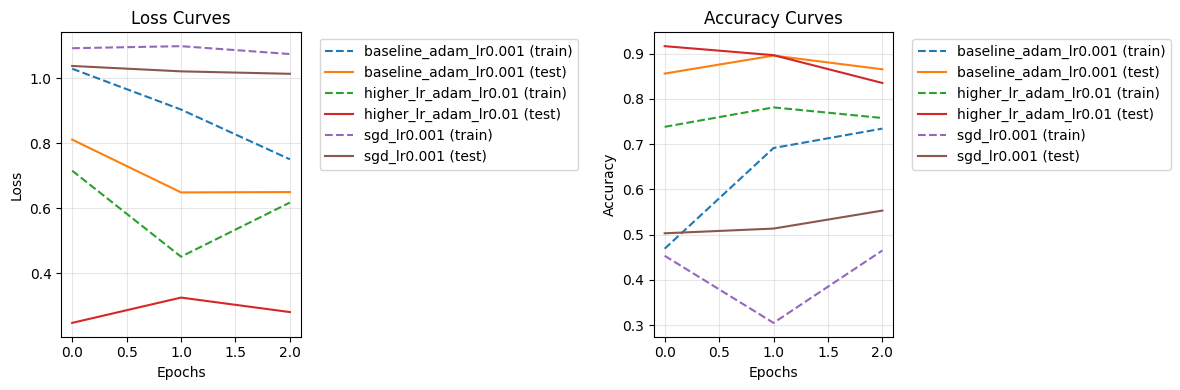

In [55]:
# Plot learning curves
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for exp in experiments:
    epochs_range = range(len(exp["history"]["train_loss"]))
    
    # Plot loss
    axes[0].plot(epochs_range, exp["history"]["train_loss"], 
                 label=f"{exp['name']} (train)", linestyle='--')
    axes[0].plot(epochs_range, exp["history"]["test_loss"], 
                 label=f"{exp['name']} (test)")
    
    # Plot accuracy
    axes[1].plot(epochs_range, exp["history"]["train_acc"], 
                 label=f"{exp['name']} (train)", linestyle='--')
    axes[1].plot(epochs_range, exp["history"]["test_acc"], 
                 label=f"{exp['name']} (test)")

axes[0].set_title("Loss Curves")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].grid(True, alpha=0.3)

axes[1].set_title("Accuracy Curves")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Accuracy")
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Alternative way to launch TensorBoard if %tensorboard doesn't work
from tensorboard import notebook
import os

# Get the log directory
log_dir = "runs"

# Launch TensorBoard
notebook.start("--logdir {} --port 6008".format(os.path.abspath(log_dir)))

## Troubleshooting TensorBoard

If TensorBoard doesn't load in the notebook, try these alternatives:

### Option 1: Terminal Launch
```bash
# In a new terminal:
source venv/bin/activate  # Activate your environment
tensorboard --logdir runs --reload_interval 1
# Then open browser at http://PUBLIC-IP:6006
```

### Option 2: Kill Previous TensorBoard
```bash
# If port is already in use:
lsof -ti:6006 | xargs kill -9  # On Mac/Linux
# Or just use a different port:
tensorboard --logdir runs --port 6007
```

### Option 3: Alternative Notebook Method

## 10. Key Insights from Experiments

Based on our experiments, we can observe:

### Learning Rate Impact
- **Lower LR (0.001)**: More stable training, gradual improvement
- **Higher LR (0.01)**: Faster initial progress but may be less stable

### Optimizer Comparison
- **Adam**: Adaptive learning rates, generally faster convergence
- **SGD**: Simpler but may need more tuning

### Benefits of Tracking
- ✅ **Reproducibility**: All hyperparameters logged
- ✅ **Comparison**: Easy to identify best configuration
- ✅ **Insights**: Visual understanding of training dynamics
- ✅ **Debugging**: Can spot issues like overfitting early

## Summary and Key Takeaways

In this lab, we learned:

1. **Why Track Experiments** — Essential for reproducible ML development
2. **TensorBoard Integration** — Simple API with `SummaryWriter`
3. **What to Track** — Loss, accuracy, hyperparameters, model graphs
4. **Experiment Organization** — Naming conventions and directory structure
5. **Comparison Benefits** — Easily identify best configurations

### TensorBoard Workflow Recap

```python
# 1. Create writer
writer = SummaryWriter('runs/experiment_name')

# 2. Log metrics during training
writer.add_scalar('Loss/train', loss, epoch)
writer.add_scalar('Accuracy/test', accuracy, epoch)

# 3. View in browser
# tensorboard --logdir runs

# 4. Close writer
writer.close()
```

### Best Practices

- ✅ Use descriptive experiment names
- ✅ Log hyperparameters at the start
- ✅ Track both train and validation metrics
- ✅ Use timestamps to avoid overwriting
- ✅ Close writers when done

### Next Steps

- **Lab 02**: Explore data scaling experiments
- **Lab 03**: Design full factorial experiments
- **Advanced**: Add custom metrics, embeddings, and more

Remember: *"What gets measured gets managed"* — tracking experiments is the foundation of systematic ML development!